In [27]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib.blob_extraction import img_preprocess_mask, img_preprocess, blob_detect, get_nodes_pos
from lib.graph_generate import Plot_Voronoi_Graph, voronoi_graph_built
from lib.voronoi_generate import TransformVoronoi_331, cal_3d_Voronoi, plot_3d_Voronoi

(1) Read Image

Raw image size:  (340, 340, 3)


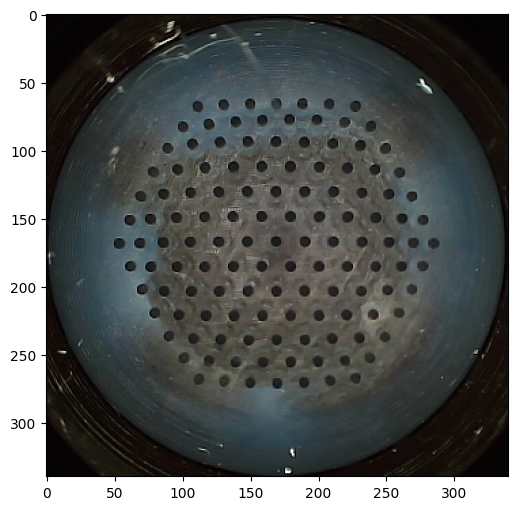

In [28]:
test_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\trans\2_1_1_1\frames_bw\frame_0_0.png" ## round

frame= cv2.imread(test_data_path)
print("Raw image size: ", frame.shape)

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.show()

(2) Image Preprocess

Processed image size:  (300, 300)


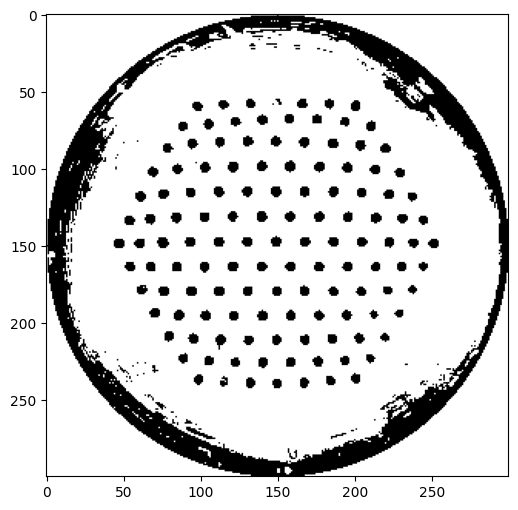

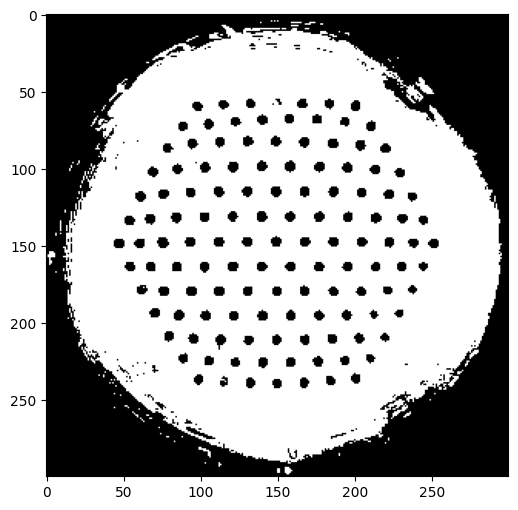

In [29]:
processed, white_mask, erosion = img_preprocess_mask(frame, 
                                                     erosion = False,
                                                     resize_x = 300, 
                                                     resize_y = 300, 
                                                     kernel_size = 1, 
                                                     binary_threshold = 50, 
                                                     circle_x_bias= 0, 
                                                     circle_y_bias=0,
                                                     circle_radius_bias=0)  

print("Processed image size: ", processed.shape)

plt.figure(figsize=(6, 6))
plt.imshow(white_mask, cmap = 'gray')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(processed, cmap = 'gray')
plt.show()

# Construct a circular mask
mask = np.zeros(processed.shape[:2], dtype=np.uint8)
center = (processed.shape[1] // 2, processed.shape[0] // 2)
radius = 110   

cv2.circle(mask, center, radius, 255, -1)  

# Apply mask
masked_processed = cv2.bitwise_and(processed, processed, mask=mask)

# blob
keypoints = blob_detect(masked_processed, minArea=5, blobColor=0,
                        minCircularity=0.1, minConvexity=0.01,
                        minInertiaRatio=0.01, thresholdStep=5,
                        minDistBetweenBlobs=2.0, minRepeatability=2)

im_with_keypoints = cv2.drawKeypoints(
    masked_processed, keypoints, np.array([]),
    (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)


(3) Blob Detection

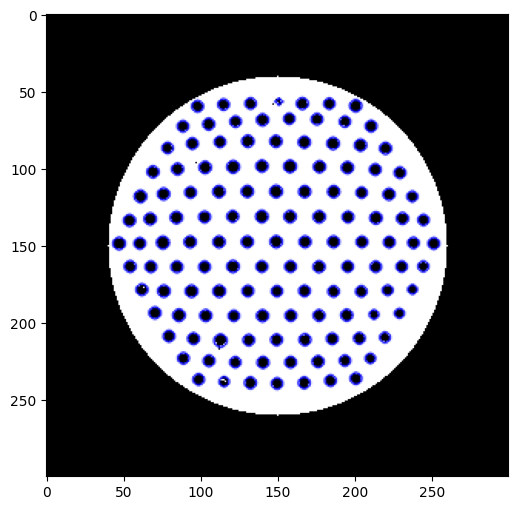

In [30]:
keypoints = blob_detect(masked_processed, minArea = 5, blobColor = 0, 
                minCircularity = 0.1, minConvexity = 0.01, 
                minInertiaRatio = 0.01, thresholdStep = 5,
                minDistBetweenBlobs = 2.0, minRepeatability = 2)

im_with_keypoints = cv2.drawKeypoints(masked_processed, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(6, 6))
plt.imshow(im_with_keypoints)
plt.show()

(4) Node Pos Normalization

In [31]:
nodes_pos = get_nodes_pos(keypoints)  

nodes_pos_norm = np.squeeze(nodes_pos)
_, unindx = np.unique(nodes_pos_norm, return_index=True, axis=0)
unindx = np.sort(unindx)
nodes_pos_norm = nodes_pos_norm[unindx]
nodes_pos_norm = (nodes_pos_norm - np.median(nodes_pos_norm))
print("Node position size: ", nodes_pos_norm.shape)

Node position size:  (127, 2)


（5） Voronoi Graph Build

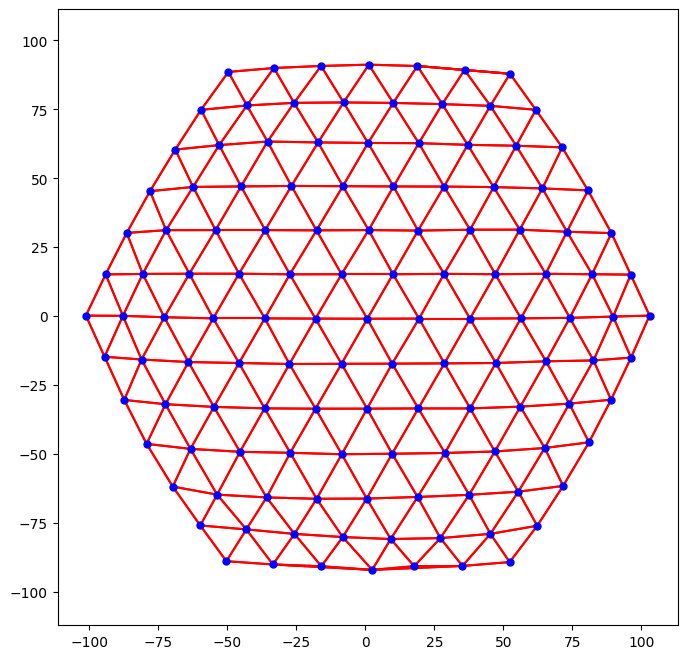

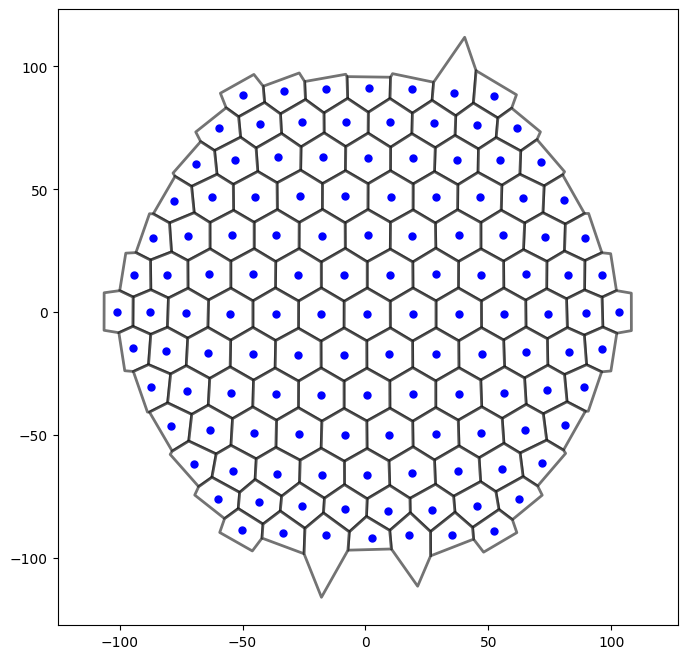

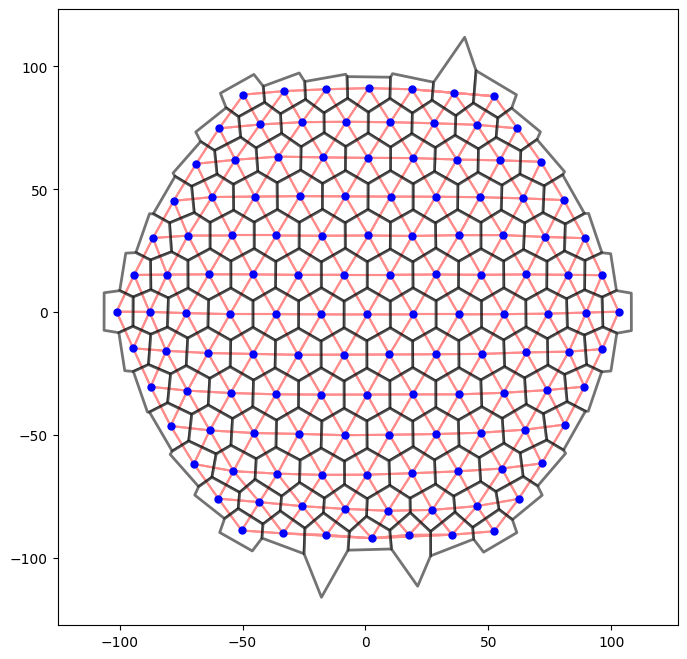

In [32]:
## Calculate voronoi tesseleation
Axx_canon, Cxx_canon, Cyy_canon, XY_canon = TransformVoronoi_331(borderScale=1.1).transform(nodes_pos)

clean_nodes_edges, nodes_pos_norm = voronoi_graph_built(nodes_pos)

p1 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotGraph(cell_scale_fact=1)
p2 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotVoronoi(cell_scale_fact=1)
p3 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotVoronoiGraph(cell_scale_fact=1)

## Plot Voronoi

Xgrid, Ygrid, Z_canon = cal_3d_Voronoi(Axx_canon, Cxx_canon, Cyy_canon, pool_neighbours = 3, num_interp_points = 50)



def construct_Voronoi_graph(image_dir, kernel_size = 2, resize_x=300, resize_y=300, tip_num=331, k=6):

    frame= cv2.imread(image_dir)

    processed = img_preprocess(frame, 
                                erosion = True,
                                resize_x = 256, 
                                resize_y = 256, 
                                kernel_size = 1, 
                                binary_threshold = 40, 
                                circle_x_bias=-2, 
                                circle_y_bias=-3,
                                circle_radius_bias=-20)  ## round
    
    keypoints = blob_detect(processed, minArea = 10, blobColor = 255, 
                minCircularity = 0.01, minConvexity = 0.01, 
                minInertiaRatio = 0.01, thresholdStep = 5,
                minDistBetweenBlobs = 3, minRepeatability = 3)
    
    nodes_pos = get_nodes_pos(keypoints)

    ## Calculate voronoi tesseleation
    Axx_canon, Cxx_canon, Cyy_canon, XY_canon = TransformVoronoi_331(borderScale=1.1).transform(nodes_pos)

    clean_nodes_edges, nodes_pos_norm = voronoi_graph_built(nodes_pos)

    Xgrid, Ygrid, Z_canon = cal_3d_Voronoi(Axx_canon, Cxx_canon, Cyy_canon, pool_neighbours=3, num_interp_points=50)

    return Axx_canon, Cxx_canon, Cyy_canon, XY_canon, clean_nodes_edges



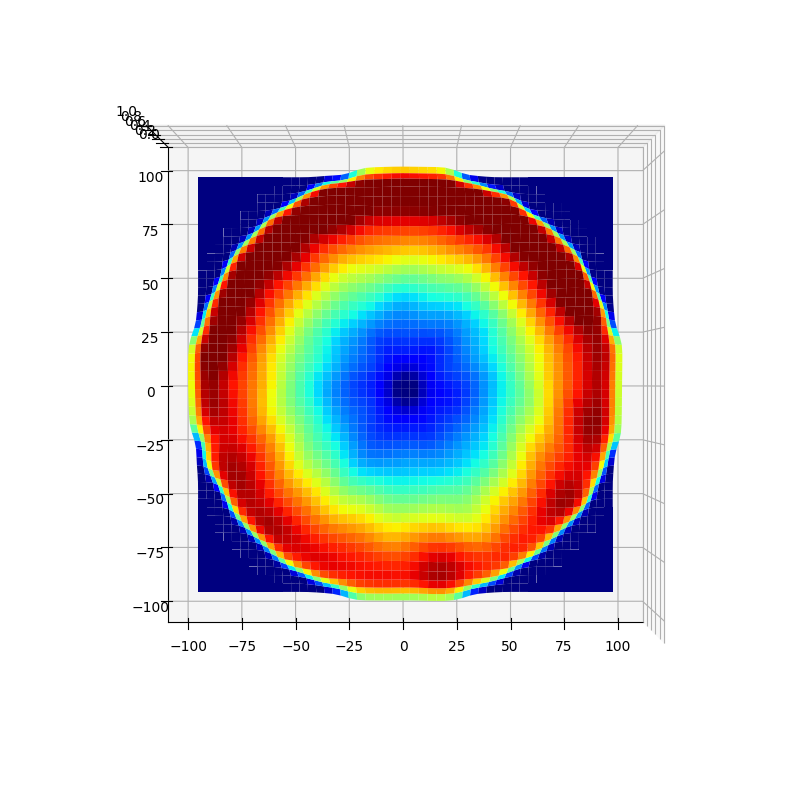

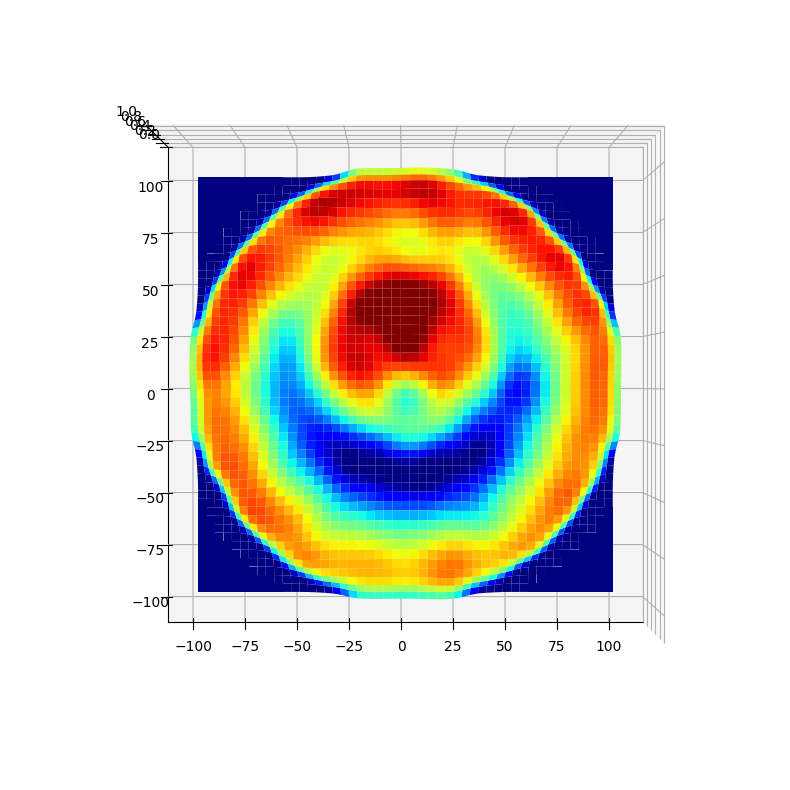

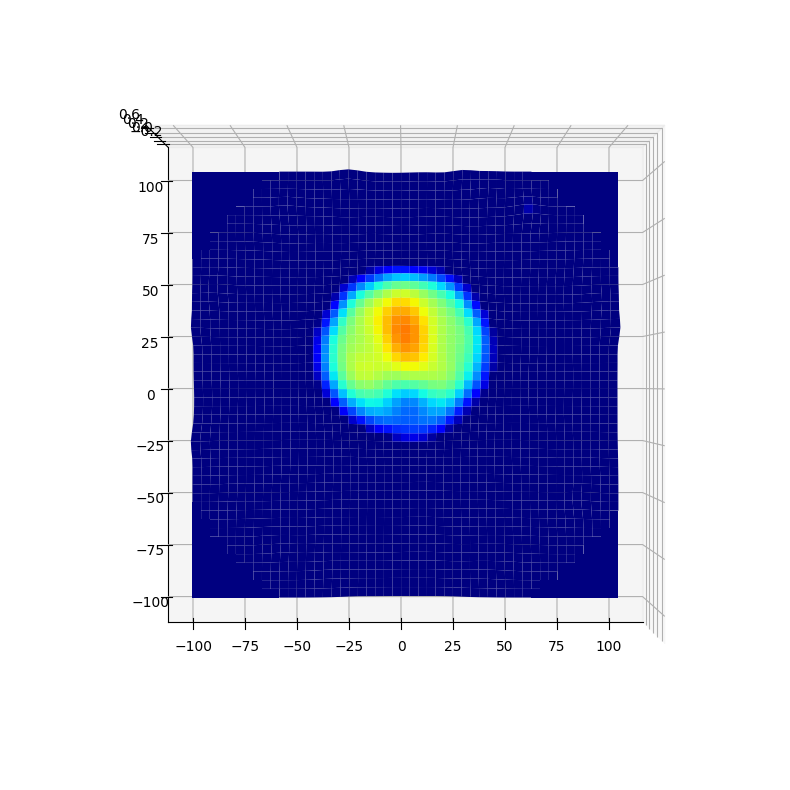

In [33]:
ref_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\331\model_surface2d\frames_bw\frame_0_0.png" ## ref round example
test_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\331\model_surface2d\frames_bw\frame_4000_0.png" ## test round example

Axx_canon_r, Cxx_canon_r, Cyy_canon_r, XY_canon_r, XY_edges_r = construct_Voronoi_graph(ref_data_path)

Axx_canon_t, Cxx_canon_t, Cyy_canon_t, XY_canon_t, XY_edges_t = construct_Voronoi_graph(test_data_path)

Xgrid_r, Ygrid_r, Z_canon_r = cal_3d_Voronoi(Axx_canon_r, Cxx_canon_r, Cyy_canon_r, pool_neighbours = 3, num_interp_points = 50)

Xgrid_t, Ygrid_t, Z_canon_t = cal_3d_Voronoi(Axx_canon_t, Cxx_canon_t, Cyy_canon_t, pool_neighbours = 3, num_interp_points = 50)

z_canon_diff = Z_canon_t - Z_canon_r   ## calculate the difference between ref voronoi graph and test voronoi graph

plot_3d_Voronoi(Xgrid_r, Ygrid_r, Z_canon_r, vmin=0.1, vmax=0.9)
plot_3d_Voronoi(Xgrid_t, Ygrid_t, Z_canon_t, vmin=0.1, vmax=0.9)
plot_3d_Voronoi(Xgrid_t, Ygrid_t, z_canon_diff, vmin=0.1, vmax=0.9)